<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/computer_vision/alexnet_cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training AlexNet on Cifar100

**Mission Statement**

1. Upgrade our exercise on AlexNet to Cifar100
2. Comparing top1 and top5 accuracy with state-of-art model


## Notebook Preparation

In [1]:
!pip install -q git+https://github.com/ronald-hk-chung/sstorch.git

from sstorch.learner import SSTLearner
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


## Introduction to Cifar-100 datasets

The **CIFAR-100** dataset (Canadian Institute for Advanced Research, 100 classes) is a subset of the Tiny Images dataset and consists of 60000 32x32 color images. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. There are 600 images per class. Each image comes with a "fine" label (the class to which it belongs) and "coarse" label (the superclass to which it belongs). There are 500 training images and 100 testing images per class.

The criteria for deciding whether an image belongs to a class were as follows:

* The class name should be high on the list of likely answers to the question “What is in this picture?”
* The image should be photo-realistic. Labelers were instructed to reject line drawings.
* The image should contain only one prominent instance of the object to which the class refers.
* The object may be partially occluded or seen from an unusual viewpoint as long as its identity is still clear to the labeler.

Reference: https://www.cs.toronto.edu/~kriz/cifar.html



In [2]:
import torchvision
from torchvision.datasets import CIFAR100

train_ds = CIFAR100(root='data',
                    train=True,
                    download=True)

valid_ds = CIFAR100(root='data',
                    train=False,
                    download=True)

100%|██████████| 169001437/169001437 [00:05<00:00, 32069039.55it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [3]:
# To get the mean and standard deviations of cifar10
data_shape = train_ds.data.shape
data_mean = train_ds.data.mean(axis=(0, 1, 2))/255
data_std = train_ds.data.std(axis=(0, 1, 2))/255

print(f'Shape of Data: {data_shape}')
print(f'Mean of Data: {data_mean}')
print(f'Std of Data: {data_std}')

Shape of Data: (50000, 32, 32, 3)
Mean of Data: [0.50707516 0.48654887 0.44091784]
Std of Data: [0.26733429 0.25643846 0.27615047]


Generating transforms for data
* tfms for valid_ds which only includes `Resize`, `ToTensor` and `Normalize` wiht the above calculated mean and standard deviations
* tfms_augmented for train_ds which has added `TrivialAugmentWide` for data augmentation
* rtfms for reversing the transforms image to PIL

In [4]:
import torchvision.transforms as T
from torch.utils.data import DataLoader

# Define transforms from PIL to Tensors
tfms = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

# Define transforms from PIL to Tensors with Data Augmentation
tfms_augmented = T.Compose([
    T.Resize(size=(224, 224)),
    T.TrivialAugmentWide(num_magnitude_bins=10),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

# Define reverse transforms from Tensors to PIL (for visualisation)
rtfms = T.Compose([
    T.Normalize(mean=[0.0] * 3,
                std=list(map(lambda x: 1 / x, data_std))),
    T.Normalize(mean=list(map(lambda x: -x, data_mean)),
                std=[1.0] * 3),
    T.ToPILImage()
])

# Apply transforms to dataset
train_ds = CIFAR100(root='data',
                    train=True,
                    transform=tfms_augmented,
                    download=True)

valid_ds = CIFAR100(root='data',
                    train=False,
                    transform=tfms,
                    download=True)


# Create DataLoader for train/valid dataset
train_dl = DataLoader(dataset=train_ds,
                      batch_size=128,
                      shuffle=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=128,
                      shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Note that PyTorch torchvision `CIFAR100` dataset only provides fine label (the class it belongs to). Below shows the mapping of superclasses vs fine classes

In [5]:
superclass_dict = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
    'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
    'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
    'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
    'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
    'household electrical devices': ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
    'household furniture':['bed', 'chair', 'couch', 'table', 'wardrobe'],
    'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
    'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
    'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
    'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
    'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
    'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
    'non-insec invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
    'people': ['baby', 'boy', 'girl', 'man', 'woman'],
    'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
    'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
    'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
    'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
    'vehicles 2':['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
    }

Prepare for below variables:
1. classes - list of classes from CIFAR-100
2. class_to_idx = dict that map class name to label
3. superclasses - list of superclasses from CIFAR-100
4. superclass_to_idx - dict that map superclass names to label
5. superclass_map - array of mapping from fine classes to superclasses

In [6]:
# Define classes and classes_to_idx
classes = train_ds.classes
class_to_idx = train_ds.class_to_idx

# Define superclasses and superclasses_to_idx
superclasses = list(superclass_dict.keys())
superclass_to_idx = {k: i for i, k in enumerate(superclasses)}

# Generate a superclass_map which maps each fine class to its superclass
superclass_labels = []
for cls in classes:
    for superclass, superclass_list in superclass_dict.items():
        if cls in superclass_list:
            superclass_labels.append(superclass_to_idx[superclass])

superclass_labels = np.array(superclass_labels)

In [8]:
print('Mapping of fine classes to superclasses')
superclass_labels

Mapping of fine classes to superclasses


array([ 4,  1, 14,  8,  0,  6,  7,  7, 18,  3,  3, 14,  9, 18,  7, 11,  3,
        9,  7, 11,  6, 11,  5, 10,  7,  6, 13, 15,  3, 15,  0, 11,  1, 10,
       12, 14, 16,  9, 11,  5,  5, 19,  8,  8, 15, 13, 14, 17, 18, 10, 16,
        4, 17,  4,  2,  0, 17,  4, 18, 17, 10,  3,  2, 12, 12, 16, 12,  1,
        9, 19,  2, 10,  0,  1, 16, 12,  9, 13, 15, 13, 16, 19,  2,  4,  6,
       19,  5,  5,  8, 19, 18,  1,  2, 15,  6,  0, 17,  8, 14, 13])

## Showing a batch of images with classes and superclasses

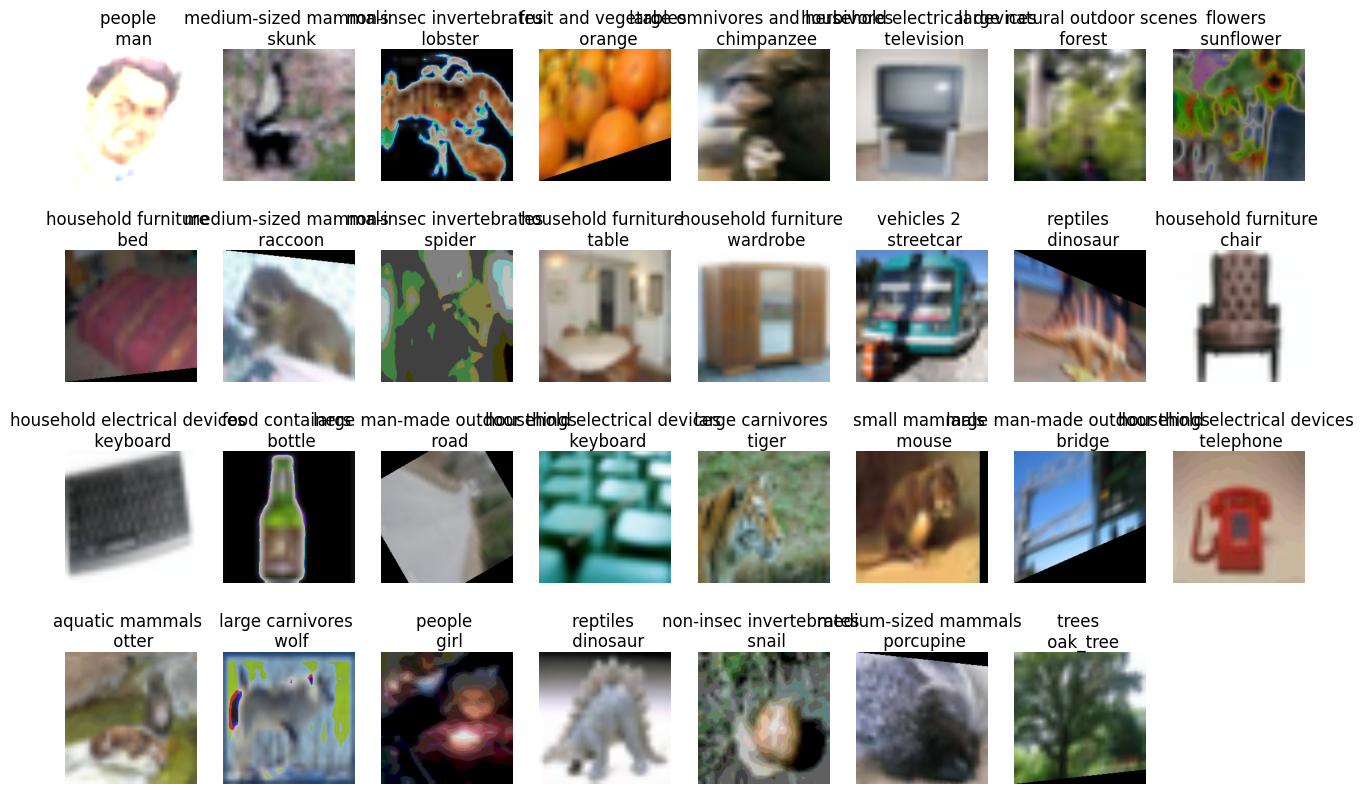

In [9]:
import matplotlib.pyplot as plt
from textwrap import wrap

images, labels = next(iter(train_dl))

# Show one batch of data
fig = plt.figure(figsize=(16, 10))
rows, cols = 4, 8
for i, image in enumerate(images[:31]):
    plt.subplot(rows, cols, i+1)
    plt.imshow(rtfms(image))
    fineclass = classes[labels[i]]
    superclass = superclasses[superclass_labels[labels[i]]]
    plt.title(f'{superclass} \n {fineclass}', loc='center', wrap=True)
    plt.axis(False)

## Prepare for model training

* Using `nn.CrossEntropyLoss` as loss_fn

* For metric_fn, we will need to define for
    1. accuracy score for fine classes
    2. top_5_accuracy for accuracy score for fine classes within top-5 predictions
    3. accuracy_super for accuracy score for superclasses

* We will use AlexNet built in `sstorch` - refer to https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/alexnet_cifar10.ipynb

* using Adam as optimizer

* setting up learner class from SSTLearner for training


In [10]:
import torch.nn as nn
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sstorch.vision import AlexNet

# Define loss_fn
loss_fn = nn.CrossEntropyLoss()

# Define metric_fn that returns dictionary of accuracy, top_5_accuracy and accuracy_super
def metric_fn(y_logits, y):
    # Get Probs and Probabilities using softmax and argmax
    y_probs = y_logits.softmax(dim=-1).detach().cpu().numpy()
    y_preds = y_probs.argmax(axis=-1)
    y = y.detach().cpu().numpy()

    # Transform to superclass labels
    y_preds_super = superclass_labels[y_preds]
    y_super = superclass_labels[y]

    accuracy = accuracy_score(y, y_preds)
    top_5_accuracy = top_k_accuracy_score(y, y_probs, k=5, labels=list(range(100)))
    accuracy_super = accuracy_score(y_super, y_preds_super)
    return {'accuracy': accuracy,
            'top_5_accuracy': top_5_accuracy,
            'accuracy_super': accuracy_super}

# Retreive AlexNet from sstorch.vision
model = AlexNet(in_channels=3, num_classes=100)

# Define optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-4)

learner = SSTLearner(model=model,
                     loss_fn=loss_fn,
                     metric_fn=metric_fn,
                     optimizer=optimizer,
                     train_dataloader=train_dl,
                     valid_dataloader=valid_dl)

Checking our parameters using torchinfo

In [11]:
learner.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [128, 3, 224, 224]   [128, 100]           --                   True
├─Sequential (features)                  [128, 3, 224, 224]   [128, 256, 6, 6]     --                   True
│    └─Sequential (conv_block1)          [128, 3, 224, 224]   [128, 96, 27, 27]    --                   True
│    │    └─Conv2d (conv1)               [128, 3, 224, 224]   [128, 96, 55, 55]    34,944               True
│    │    └─ReLU (relu1)                 [128, 96, 55, 55]    [128, 96, 55, 55]    --                   --
│    │    └─LocalResponseNorm (lrn1)     [128, 96, 55, 55]    [128, 96, 55, 55]    --                   --
│    │    └─MaxPool2d (maxpool1)         [128, 96, 55, 55]    [128, 96, 27, 27]    --                   --
│    └─Sequential (conv_block2)          [128, 96, 27, 27]    [128, 256, 13, 13]   --                   True
│    │    └─Conv2d (

Find the optimal learning rate by LR Range Test

  0%|          | 0/100 [00:00<?, ?it/s]

Max Gradient: 2.53E-03 | Lowest Loss: 2.68E-03


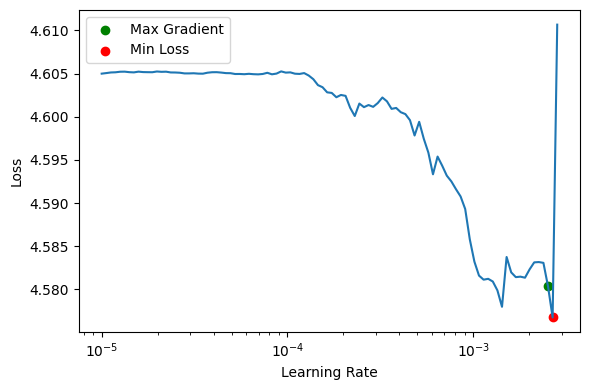

In [12]:
learner.lr_range_test(end_lr=3e-3, start_lr=1e-5)

In [16]:
learner.set_lr(1e-4)

In [17]:
learner.train(10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11 | LR: 1.0E-04 | train_loss: 1.931 | valid_loss: 1.827 
train_metric: {'accuracy': 0.496, 'top_5_accuracy': 0.772, 'accuracy_super': 0.612}
valid_metric: {'accuracy': 0.516, 'top_5_accuracy': 0.792, 'accuracy_super': 0.646}
----------------------------------------------------------------------------------------------------
Epoch: 12 | LR: 1.0E-04 | train_loss: 1.85 | valid_loss: 1.804 
train_metric: {'accuracy': 0.519, 'top_5_accuracy': 0.785, 'accuracy_super': 0.631}
valid_metric: {'accuracy': 0.52, 'top_5_accuracy': 0.799, 'accuracy_super': 0.651}
----------------------------------------------------------------------------------------------------
Epoch: 13 | LR: 1.0E-04 | train_loss: 1.783 | valid_loss: 1.791 
train_metric: {'accuracy': 0.533, 'top_5_accuracy': 0.796, 'accuracy_super': 0.642}
valid_metric: {'accuracy': 0.531, 'top_5_accuracy': 0.804, 'accuracy_super': 0.654}
----------------------------------------------------------------------------------------------------


## Comparison of state-of-art model and Alexnet results in paperswithcode

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/cifar100_leaderboard.png?raw=true">

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/alexnet_cifar100_ranking.PNG?raw=true">

Notebook Recap:

1. We managed to train the AlexNet to achieve ~55% valid accuracy and >80% top-5 accuracy which is only slightly below paperswithcode leaderboard result in AlexNet with 20 epochs
2. Cifar100 is a much more complex dataset that will require a deeper model to learn for better accuracy